In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5", temperature=0)

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Doctor(BaseModel):
    name: str = Field(
        description="Name of the doctor."
    )
    qualifications: str = Field(
        description="Qualifications of the doctor",
    )
    specialization: str = Field(
        description="Specialization of the dcotor i.e., cardiologist, dermatologist, orthopedist, etc.",
    )
    experience: int = Field(
        description="Number of years of work experience of the doctor"
    )
    description: str = Field(
        description="Description of the doctor's place of work, achievements, etc.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nQualifications: {self.qualifications}\nSpecialization: {self.specialization}\nExperience: {self.experience}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    doctors: List[Doctor] = Field(
        description="Comprehensive list of doctors with their specializations, place of work and qualifications.",
    )

class GenerateDoctorsState(TypedDict):
    symptom: str 
    max_doctors: int 
    human_feedback: str 
    doctors: List[Doctor]

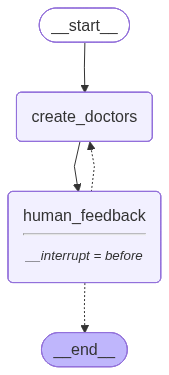

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

doctor_instructions="""You are tasked with creating a set of Doctors. Follow these instructions carefully:

1. First, take a look at the symptom: {symptom}
        
2. Examine any feedback that has been optionally provided to guide creation of the doctor personas: 
        
{human_feedback}
    
3. Determine the most suitable specialists who can diagnose the symptom {symptom}.
                    
4. Pick the top {max_doctors} specialists most suited for the symptom {symptom}.

5. Assign one doctor for each specialization."""

def create_doctors(state: GenerateDoctorsState):
    
    """ Create doctors """
    
    symptom=state['symptom']
    max_doctors=state['max_doctors']
    human_feedback=state.get('human_feedback', '')
        
    structured_llm = llm.with_structured_output(Perspectives)

    system_message = doctor_instructions.format(symptom=symptom,
                                                            human_feedback=human_feedback, 
                                                            max_doctors=max_doctors)
 
    doctors = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the list of doctors.")])

    return {"doctors": doctors.doctors}

def human_feedback(state: GenerateDoctorsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateDoctorsState):
    """ Return the next node to execute """

    human_feedback=state.get('human_feedback', None)
    if human_feedback:
        return "create_doctors"
    
    return END
 
builder = StateGraph(GenerateDoctorsState)
builder.add_node("create_doctors", create_doctors)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_doctors")
builder.add_edge("create_doctors", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_doctors", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Creating a list of doctors
max_doctors = 3 
symptom = "I am having a pain in my lungs"
thread = {"configurable": {"thread_id": "1"}}
doctors=()
for event in graph.stream({"symptom":symptom,"max_doctors":max_doctors,}, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)  

Name: Dr. Aisha Menon, MD, FCCP
Experience(in years): 14
Qualification: MD, Internal Medicine; Fellowship in Pulmonary & Critical Care Medicine; Board Certified in Pulmonary Disease and Critical Care; FCCP
Specialization: Pulmonologist
Description: Senior Consultant Pulmonologist at City Respiratory Institute. Leads pleural disease and lung function clinics, with expertise in pleuritic chest pain, pulmonary embolism evaluation, pneumonia, asthma, COPD, and interstitial lung disease. Performs diagnostic bronchoscopy and ultrasound-guided pleural procedures; multiple peer-reviewed publications in respiratory medicine.
--------------------------------------------------
Name: Dr. Marco Alvarez, MD, FACEP
Experience(in years): 12
Qualification: MD; Residency in Emergency Medicine; Board Certified in Emergency Medicine; ACLS, ATLS, PALS certified; FACEP
Specialization: Emergency Medicine Physician
Description: Attending Emergency Physician at a Level I Trauma Center. Specializes in rapid ass

In [7]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
graph.update_state(thread, {"human_feedback": 
                            "Add a Lung cancer specialist"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cc5c6-db15-69d2-8002-437160076cc8'}}

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)

Name: Dr. Aisha Menon, MD, FCCP
Experience(in years): 14
Qualification: MD, Internal Medicine; Fellowship in Pulmonary & Critical Care Medicine; Board Certified in Pulmonary Disease and Critical Care; FCCP
Specialization: Pulmonologist
Description: Senior Consultant Pulmonologist at City Respiratory Institute. Leads pleural disease and lung function clinics, with expertise in pleuritic chest pain, pulmonary embolism evaluation, pneumonia, asthma, COPD, and interstitial lung disease. Performs diagnostic bronchoscopy and ultrasound-guided pleural procedures; multiple peer-reviewed publications in respiratory medicine.
--------------------------------------------------
Name: Dr. Marco Alvarez, MD, FACEP
Experience(in years): 12
Qualification: MD; Residency in Emergency Medicine; Board Certified in Emergency Medicine; ACLS, ATLS, PALS certified; FACEP
Specialization: Emergency Medicine Physician
Description: Attending Emergency Physician at a Level I Trauma Center. Specializes in rapid ass

In [10]:
further_feedack = None
graph.update_state(thread, {"human_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cc5c7-82ae-6e85-8004-fb8ffb125cb0'}}

In [11]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
doctors = final_state.values.get('doctors')

In [13]:
final_state.next

()

In [14]:
for doctor in doctors:
    print(f"Name: {doctor.name}")
    print(f"Experience(in years): {doctor.experience}")
    print(f"Qualification: {doctor.qualifications}")
    print(f"Specialization: {doctor.specialization}")
    print(f"Description: {doctor.description}")
    print("-" * 50) 

Name: Dr. Maya Srinivasan
Experience(in years): 14
Qualification: MD, FCCP; Board Certified in Internal Medicine, Pulmonary Disease, and Critical Care Medicine; Fellowship in Pulmonary & Critical Care
Specialization: Pulmonologist
Description: Senior Consultant and Section Chief of Pulmonary Medicine at Bayview University Hospital. Expertise in pleuritic chest pain, pulmonary embolism workups, pneumonia, and pleural diseases; performs advanced diagnostics including spirometry, diffusion studies, EBUS bronchoscopy, and thoracic ultrasound. Leads a rapid-access clinic for acute chest and lung symptoms.
--------------------------------------------------
Name: Dr. Carlos E. Moreno
Experience(in years): 16
Qualification: MD, MSc (Clinical Research); Board Certified in Medical Oncology; Fellowship in Thoracic Oncology
Specialization: Thoracic Oncologist (Lung Cancer Specialist)
Description: Medical Oncologist at Metropolitan Cancer Center and lead of the Multidisciplinary Lung Cancer Program